In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import backward
# from coolmom import SGD

import numpy as np
import math
import pickle
import os
from sklearn.utils import shuffle
from tqdm import tqdm
import ipdb

import Utils.util as util

np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

In [2]:
CRASH_fname = 'CRASH_FE_filtered_subsampled_noscaler.pkl'

with open(CRASH_fname, 'rb') as handle:
    F_t, scs, adj_mx, adj_mx_idx, _input, _gt, coeffs, \
    inv_mapping, region_assignment, nTrain, nValid, \
    nTest, scaler_in, scaler_out = pickle.load(handle)
    
# CRASH_fname = 'CRASH_Fonly.pkl'
# with open(CRASH_fname, 'rb') as handle:
#     F_t, scs, adj_mx, adj_mx_idx, _input, _gt, region_assignment, \
#     nTrain, nValid, nTest, scaler_in, scaler_out = pickle.load(handle)


### prep EEG coefficients data

In [100]:
''' for loading the calculated eeg wavelet coefficients and select only 1 freq'''
freq_idx = 0 #32,57
coeffs = []
for i in tqdm(range(1,4)):
#     tmp = np.load('eeg_mat_coeffs_J7Q12/eeg_mat_coeff'+str(i)+'.npy')
#     ipdb.set_trace()
    coeffs.append(np.load('eeg_mat_coeffs_J7Q12/eeg_mat_coeff'+str(i)+'.npy')[:,freq_idx])
coeffs = np.concatenate(coeffs)
print(coeffs.shape)

idxer = np.arange(32)[None, :] + np.arange(0, 14640*32 - 32 + 1, 32)[:, None]
print(idxer.shape)
input_idxer = idxer[:,:-1]
label_idxer = idxer[:,1:]

print(input_idxer)
print(label_idxer)
print(input_idxer.flatten()[:40])
print(label_idxer.flatten()[:40])

print(label_idxer.flatten()[:232500].max()) # can have at most 232500 training pairs

input_idxer = input_idxer.flatten()[:232500]
label_idxer = label_idxer.flatten()[:232500]

100%|██████████| 3/3 [01:08<00:00, 22.72s/it]


(240000, 45)
(14640, 32)
[[     0      1      2 ...     28     29     30]
 [    32     33     34 ...     60     61     62]
 [    64     65     66 ...     92     93     94]
 ...
 [468384 468385 468386 ... 468412 468413 468414]
 [468416 468417 468418 ... 468444 468445 468446]
 [468448 468449 468450 ... 468476 468477 468478]]
[[     1      2      3 ...     29     30     31]
 [    33     34     35 ...     61     62     63]
 [    65     66     67 ...     93     94     95]
 ...
 [468385 468386 468387 ... 468413 468414 468415]
 [468417 468418 468419 ... 468445 468446 468447]
 [468449 468450 468451 ... 468477 468478 468479]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41]
239999


(232500, 1, 30) (232500, 1, 30)


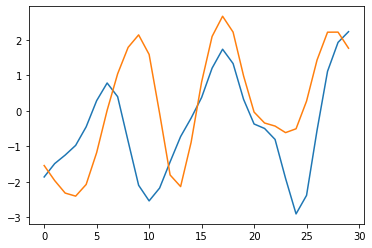

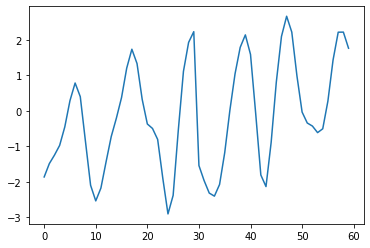

In [112]:
device = 'cuda:0'

# standardize
coeffs -= coeffs.mean()
coeffs /= coeffs.std()

x = coeffs[input_idxer][:,None,15:]
y = coeffs[label_idxer][:,None,:-15]
# y = x

print(x.shape, y.shape)

nTrain, nValid, nTest = int(len(x)*0.6), int(len(x)*0.2), int(len(x)*0.2)

plt.plot(x[20,0])
plt.plot(y[20,0])
plt.show()
plt.plot(np.concatenate((x[20,0],y[20,0]), 0))
plt.show()

x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)

### prep EEG data

(245952, 1, 1456) (245952, 1, 1456)


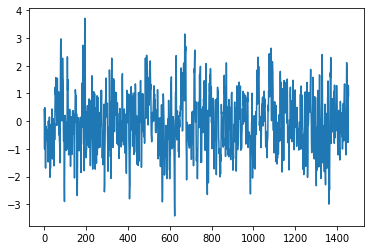

In [3]:
device = 'cuda:0'
_, num_t, num_nodes = _gt.shape

num_nodes = 10 # control train val test size for memory
nTrain, nValid, nTest = num_nodes*nTrain, num_nodes*nValid, num_nodes*nTest
x = _gt.transpose(0,2,1).reshape(-1, num_t)[:,None,:]
y = x
print(x.shape, y.shape)

plt.plot(x[0,0])
# plt.plot(y[0,0])
# plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)

### prep fmri data

81980 17570 17570
(2342400, 1, 10) (2342400, 1, 10)


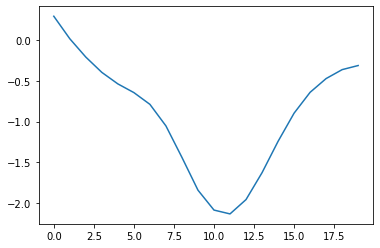

In [3]:
device = 'cuda:0'

_, num_t, num_nodes = _input.shape
# _input, _gt = shuffle(_input, _gt)

num_nodes = 10 # control train val test size for memory
nTrain, nValid, nTest = num_nodes*nTrain, num_nodes*nValid, num_nodes*nTest
print(nTrain, nValid, nTest)
x = _input.transpose(0,2,1).reshape(-1, num_t)[:,None,:]
# y = x
y = _gt.transpose(0,2,1).reshape(-1, num_t)[:,None,:]
print(x.shape, y.shape)

# plt.plot(x[0,0])
# plt.plot(y[0,0])
plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)


### Helper functions to test

In [4]:
def weighted_mse(preds, labels, null_val=np.nan):
    # assign more weights to further away points (preds:[16, 1, 10])
    num_t = preds.shape[2]
    wts = (torch.arange(num_t) + 1.0) / (torch.arange(num_t) + 1.0).sum()

    loss = (preds-labels)**2
    loss = torch.mean(loss, [0,1])

    wts = wts.to(loss.device)
    loss = loss * wts
    
    return torch.mean(loss)

def clipped_repulsion(preds):
    preds = abs(preds)
    
    preds[preds < 1e-3] = 1e-3
    loss = 1 / (abs(preds)**2)
    return torch.mean(loss)

### Extra model modules

In [66]:
# Fourier feature mapping
def fourier_mapping(x, B):
    if B is None:
        return x
    else:
#         x_proj = torch.einsum('ncvl,cw->nwvl',(2.*math.pi*x,B.T))
        x_proj = (2.*math.pi*x.squeeze()) @ B.T
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=1)[...,None]

def t2v(tau, f, out_features, w, b, w0, b0, arg=None):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    #print(v1.shape)
    return torch.cat([v1, v2], 2)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class CosineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(CosineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.f = torch.cos

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)## Testing temporal conv-deconv: only using one node's value across time


### Main models

In [113]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
    pad = (kernel_size - 1) * dilation
    return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

# def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs): 
#     ## only pad left (??? pytorch doesn't support)
#     pad = (kernel_size - 1) * dilation
#     return nn.Conv1d(in_channels, out_channels, kernel_size, padding=(pad,0), dilation=dilation, **kwargs)
# tcn & de-tcn model
class tmodel(nn.Module): # for model testing, f in, same f out
    def __init__(self, activation='sin', device='cuda:0', dropout=0.3, in_dim=1,
                residual_channels=32, dilation_channels=32, skip_channels=256,
                end_channels=64, kernel_size=2, blocks=4, layers=2):
        super(tmodel, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.device = device

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()

        self.start_conv = nn.Conv1d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=1)

#         if activation == "sin":
#             self.l1 = SineActivation(1, residual_channels)
#         elif activation == "cos":
#             self.l1 = CosineActivation(1, residual_channels)

        receptive_field = 1
        multi_factor = 2
        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))
                self.gate_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=residual_channels,kernel_size=1))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=skip_channels,kernel_size=1))
                self.bn.append(nn.BatchNorm1d(residual_channels))

                new_dilation *= multi_factor
                receptive_field += additional_scope
                additional_scope *= multi_factor


#         ## temporal transConv (de-tcn)
#         convTransK = 2
#         convTransD = 1
#         upScale = 2

#         self.end_module_conv = nn.ModuleList()
#         self.end_module_up = nn.ModuleList()
#         # for b in range(blocks):
#         #     for l in range(layers):
#         for i in range(5):
#             self.end_module_up.append(nn.Upsample(scale_factor=upScale))
#             self.end_module_conv.append(nn.ConvTranspose1d(in_channels=skip_channels, out_channels=skip_channels, 
#                            kernel_size=convTransK, dilation=convTransD))
#         self.end_mlp = nn.Sequential(
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=256, out_channels=16,
#                       kernel_size=1, bias=True),
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=16, out_channels=1,
#                       kernel_size=1, bias=True)
#             )

#         self.B = 10*np.random.normal(size=(512, 256)).astype(np.float32)
#         self.B = torch.tensor(self.B).to(device)

        # fmri
#         self.end_conv_1 = nn.Conv1d(1024, end_channels, 1, bias=True)
#         self.end_conv_2 = nn.Conv1d(end_channels, 10, 1, bias=True)
#         self.end_conv_3 = nn.Conv1d(15, 1, 1, bias=True)
        
#         # eeg
#         self.end_conv_1 = nn.Conv1d(1024, 2048, 1, bias=True)
#         self.end_conv_2 = nn.Conv1d(2048, 1456, 1, bias=True)
#         self.end_conv_3 = nn.Conv1d(182, 1, 1, bias=True)
        
        # eeg wavelet coefficients
        self.end_conv_1 = nn.Conv1d(skip_channels, end_channels*2, 1, bias=True)
        self.end_conv_2 = nn.Conv1d(end_channels*2, 30, 1, bias=True)
        
        self.receptive_field = receptive_field

    def forward(self, input, viz=False):
        # inputs: [batch_size, 1, in_len]
        ### deal with supports
        # print(self.receptive_field)
#         in_len = input.size(-1)
#         if in_len<self.receptive_field:
#             x = nn.functional.pad(input,(self.receptive_field-in_len,0))
#         else:
#             x = input
        
        x = self.start_conv(input)
#         x = input.transpose(1,2)
#         x = self.l1(x).transpose(1,2)

        if viz: # x.shape [16, 32, 15]
            ### plot features on different channels representing the same node fmri signal
            for j in range(x.shape[1]):
                plt.plot(x.detach().cpu().numpy()[0,j,:])
            plt.show()

        skip = 0

        # WaveNet layers
        for i in range(self.blocks * self.layers):
            # print(i, x.shape)
            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + --> *input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + -------------> *skip*

            #(dilation, init_dilation) = self.dilations[i]

            #residual = dilation_func(x, dilation, init_dilation, i)
            residual = x #[batch_size, residual_dim, 80, 16]

            # dilated convolution
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter[:, :, :-self.filter_convs[i].padding[0]])
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate[:, :, :-self.gate_convs[i].padding[0]])
            x = filter * gate
#             print(x.shape)
            if i % self.layers == self.layers-1:
                x = F.max_pool1d(x,2) # 2**self.layers
            # parametrized skip connection
            s = x
            s = self.skip_convs[i](s)
            try:
                if s.size(-1)*2 == skip.size(-1):
                    skip = F.max_pool1d(skip,2)
                else:
                    skip = skip[:, :, -s.size(-1):]
            except:
                skip = 0
            skip = s + skip
            
            x = self.residual_convs[i](x)
            
#             print(residual.shape, x.shape)
            x = x + residual[:, :, -x.size(-1):]
            # x = torch.cat([x, residual[:, :, :, -x.size(3):], t_rep], axis=1)
            x = self.bn[i](x) # comment off for overfitting
            
        # del residual, x
        # skip: [batch_size, hidden_dim, num_nodes, 1]

        # ### test: adding noise to hidden rep
        # skip = skip + torch.normal(torch.zeros_like(skip), 0.1*skip.std()*torch.ones_like(skip))
        # ###
        # x = self.end_module(skip)
        # if viz: # x.shape [16, 512, 200, 1]
        #     # (results look similar) each node's h-D (h being #hidden dim) feature
        #     for j in range(10):
        #         plt.plot(x.detach().cpu().numpy()[0,:,j,0])
        #     plt.show()
        #     # plot each channel's value (on all nodes)
        #     for j in range(10): 
        #         plt.plot(x.detach().cpu().numpy()[0,j,:,0])
        #     plt.show()
        
#         ipdb.set_trace()
#         x = F.max_pool1d(skip, 2)
        x = skip
        x = F.relu(x)
#         x = fourier_mapping(x,self.B)
        
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x).transpose(1,2)
#         x = self.end_conv_3(F.relu(x))
        
#         # output a single value
#         x = F.relu(self.end_conv_2(x))   
#         x = self.end_conv_3(x)

#         for i in range(5):#range(self.blocks * self.layers):       
#             x = self.end_module_up[i](x)
#             x = F.relu(self.end_module_conv[i](x))

#         x = x[...,:input.shape[-1]]
#         x = self.end_mlp(x)
        return x

# eeg
model = tmodel(blocks=4, layers=2).to(device)
model_name = "garage/exp_t_eegcoeff_mse.pth"

# fmri
# model = tmodel(blocks=3, layers=2).to(device) 
# model_name = "garage/exp_t_fmri_mse.pth"
# print(model)


In [6]:
# load pretrained model
if os.path.isfile(model_name):
    # finetune
    pretrained_dict = torch.load(model_name)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)

In [114]:
# training & validation
lrate = 3e-4
wdecay = 4e-3 #TODO: increase
repulsion_w = 1e-4

num_epoch = 50
batch_size = 32

print(nTrain, nValid, nTest)
xTrain = x[:nTrain]
xValid = x[nTrain:nTrain+nValid]

yTrain = y[:nTrain]
yValid = y[nTrain:nTrain+nValid]

if not os.path.isfile(model_name) or 'train_loss' not in locals():
    train_loss = []
    val_loss = []
min_val_loss = 1000
obj = nn.MSELoss()
for e in range(num_epoch):
#     if e%50 == 0 and e>0:
#         lrate = lrate * 0.8
#     optimizer = SGD(model.parameters(), lr=lrate, weight_decay=wdecay, momentum=0.9, beta=1e-2)
    optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)
    
    # train part
    model.train()
    # shuffle
    xTrain, yTrain = shuffle(xTrain, yTrain)
    cur_loss = []
    for i in tqdm(range(nTrain//batch_size)):
        batch_in = xTrain[i*batch_size:(i+1)*batch_size]
        batch_gt = yTrain[i*batch_size:(i+1)*batch_size]#[:,:,0:1]

        out = model(batch_in)
        loss = obj(out, batch_gt) #+ repulsion_w*clipped_repulsion(out)
        cur_loss.append(loss.item())
        
#         if i%150 == 0:
#             print(i, 'loss', loss.item(), 'mape', util.masked_mape(out, batch_gt,0).item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss.append(np.mean(cur_loss))
    print('epoch',e, 'train loss', np.mean(cur_loss))
    # validate each epoch
    model.eval()
    cur_loss = []
    for i in tqdm(range(nValid//batch_size)):
        batch_in = xValid[i*batch_size:(i+1)*batch_size]
        batch_gt = yValid[i*batch_size:(i+1)*batch_size]
        
        with torch.no_grad():
            out = model(batch_in)
        
        loss = obj(out, batch_gt) #+ repulsion_w*clipped_repulsion(out)
        cur_loss.append(loss.item())
        
    val_loss.append(np.mean(cur_loss))
    if val_loss[-1] < min_val_loss:
        min_val_loss = val_loss[-1]
        torch.save(model.state_dict(), model_name)
    print('val loss', val_loss[-1])


  0%|          | 4/4359 [00:00<02:09, 33.71it/s]

139500 46500 46500


  1%|          | 17/1453 [00:00<00:08, 167.90it/s]

epoch 0 train loss 1.1964554755984165


  0%|          | 4/4359 [00:00<02:11, 33.17it/s]

val loss 0.947335117313875


  1%|          | 17/1453 [00:00<00:08, 166.42it/s]

epoch 1 train loss 1.1991606840548041


  0%|          | 4/4359 [00:00<02:12, 32.93it/s]

val loss 0.9477449810338775


  4%|▍         | 181/4359 [00:05<02:04, 33.61it/s]


KeyboardInterrupt: 

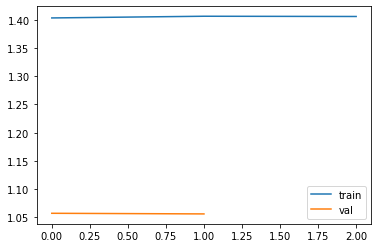

In [110]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

### Recursively predicting the next frame

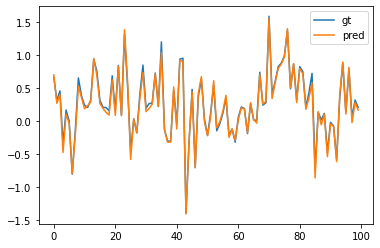

In [8]:
# test
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]
model.eval()
with torch.no_grad():
    test_out = model(xTest).detach().cpu().numpy().squeeze()

# plt.plot(yTest[:100].detach().cpu().numpy(), label='gt')
plt.plot(yTest[:,0:1][:100].detach().cpu().numpy(), label='gt')
plt.plot(test_out[:100], label='pred')
# plt.plot(xTest[:,0,-1][:100].detach().cpu().numpy().squeeze(), label='last input value')
plt.legend()

torch.Size([17570, 10]) torch.Size([17570, 10])
mape: 0.032074812799692154 cc 0.584248176050967


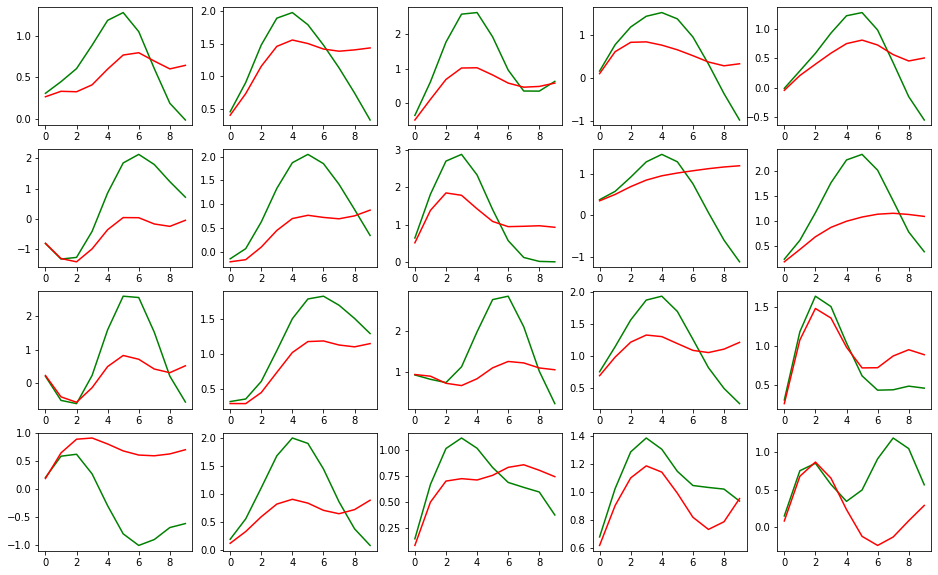

In [9]:
cur_in = xTest
pred = []

with torch.no_grad():
    for i in range(10):
        cur_out = model(cur_in)
        pred.append(cur_out)
        cur_in = torch.cat((cur_in, cur_out), 2)[:,:,1:]

pred = torch.cat(pred, 2).squeeze()
print(pred.shape, yTest.shape)
print('mape:', util.masked_mape(pred, yTest,0).item(), 'cc', util.get_cc(pred, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k].detach().cpu().numpy(), color='g')
        plt.plot(pred[k].detach().cpu().numpy(), color='r')
plt.show()

### observations
predict near future converges immediately, but predicting further-away frames need much more epochs

### Directly mapping / predicting t frames

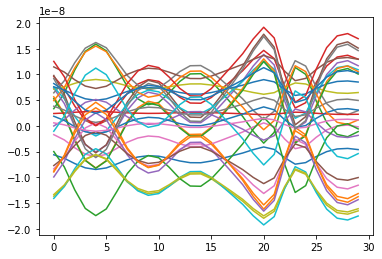

torch.Size([100, 30]) torch.Size([100, 30])
mape: 0.1259990930557251 cc nan


/home/sikun/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


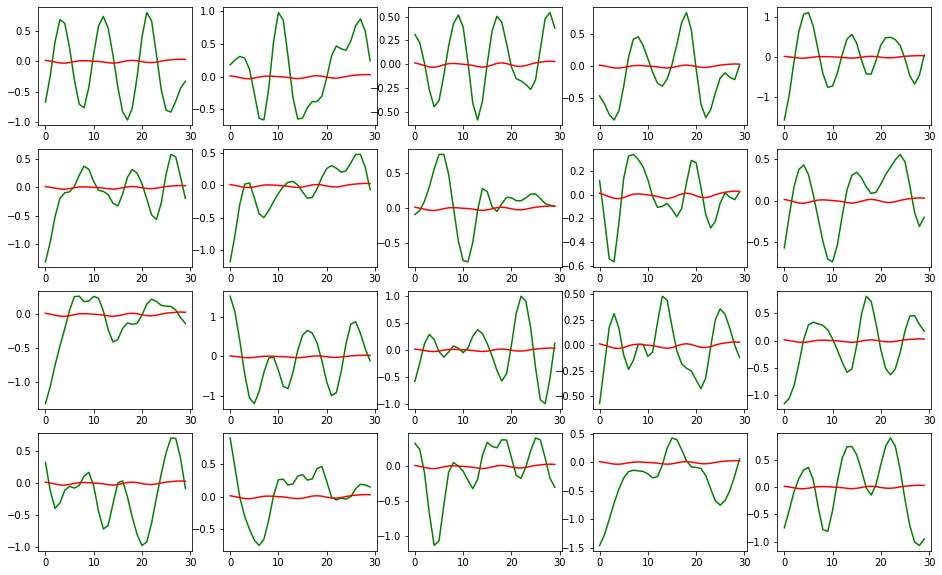

In [115]:
# test
nTest = 100
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]

model.eval()
with torch.no_grad():
    test_out = model(xTest, viz=True).squeeze()

print(yTest.shape, test_out.shape)
print('mape:', util.masked_mape(test_out, yTest,0).item(), 'cc', util.get_cc(test_out, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k+20].detach().cpu().numpy(), color='g')
        plt.plot(test_out[k+20].detach().cpu().numpy(), color='r')
plt.show()

In [13]:
print(nTrain,nValid,nTest)

59800 12800 12800


### Observations
Mapping is good.

prediction tend to converge to 0 --> this seems to happen to ARIMA as well (when predicting mean-stationary signals)

### t branches, each predict one future step. 
Also more weight on recent pred (otherwise further-away loss is dominating)

(Give up, since for the real problem EEG has so many frames, this isn't quite practical)